<a href="https://colab.research.google.com/github/GB-studyingcode/Inventory-Demand-Forecasting/blob/main/Inventory_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score,root_mean_squared_error
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Supply Chain Analytics/train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [ ]:
df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


# Feature Engineering

In [ ]:
# Dạng string
#df['year'] = df['date'].dt.split(pat ='-', expand = True)[0]
#df['month'] = df['date'].dt.split(pat ='-', expand = True)[1]
#df['day'] = df['date'].dt.split(pat ='-', expand = True)[2]

# Dạng datetime
df['year']  = df['date'].dt.year.astype('Int16')
df['month'] = df['date'].dt.month.astype('Int8')
df['day']   = df['date'].dt.day.astype('Int8')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [ ]:
df['weekend'] = (df['date'].dt.day_of_week >=5).astype('int8')


In [ ]:
import holidays

In [ ]:
usa_holiday = holidays.USA()
df['is_holiday'] = df['date'].isin(usa_holiday).astype('int8')
df.head()

,date,store,item,sales,year,month,day,weekend,is_holiday
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


In [ ]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,weekend,is_holiday,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025


In [ ]:
df['weekday'] = df['date'].dt.weekday.astype('int8')
df.head()

,date,store,item,sales,year,month,day,weekend,is_holiday,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025,5


In [ ]:
df.drop('date', axis = 1, inplace = True)

# Exploratory Data Analysis

In [ ]:
df.store.nunique()
df.item.nunique()

50

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'item'}>,
        <Axes: title={'center': 'sales'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'weekend'}>,
        <Axes: title={'center': 'is_holiday'}>,
        <Axes: title={'center': 'm1'}>],
       [<Axes: title={'center': 'm2'}>,
        <Axes: title={'center': 'weekday'}>, <Axes: >]], dtype=object)

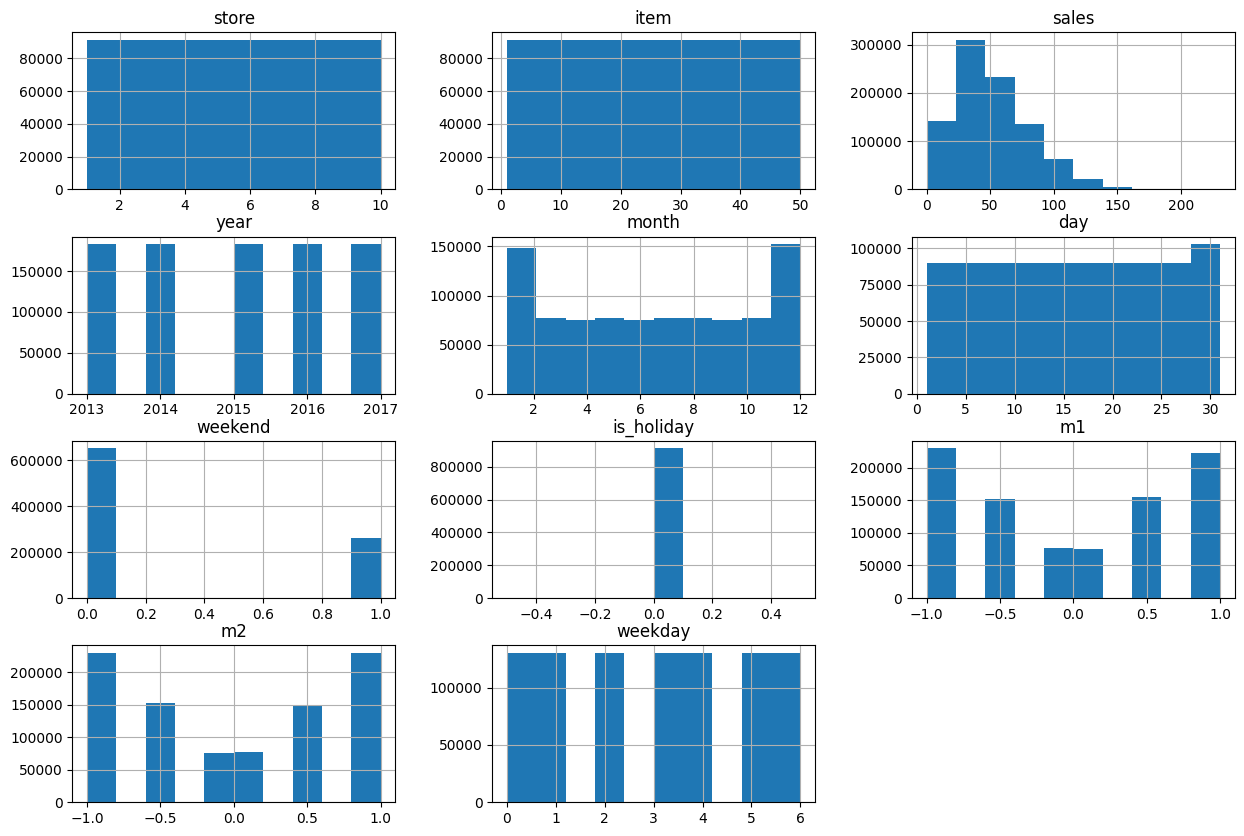

In [ ]:
df.hist(figsize = (15,10))

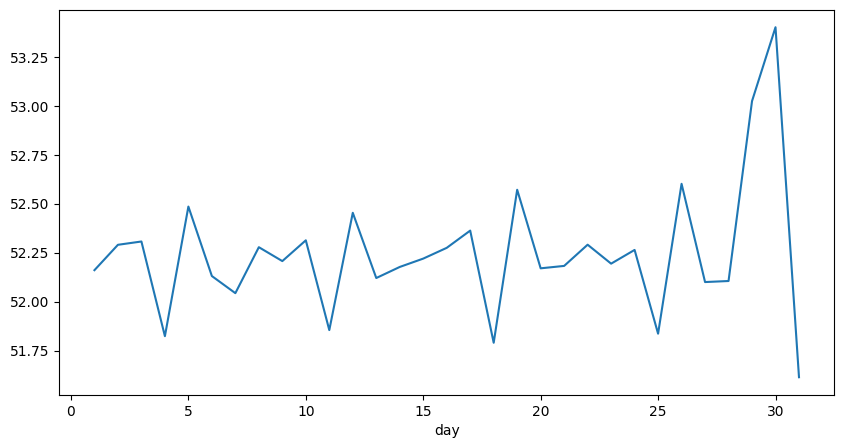

In [ ]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

/tmp/ipython-input-700605786.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['sales'])


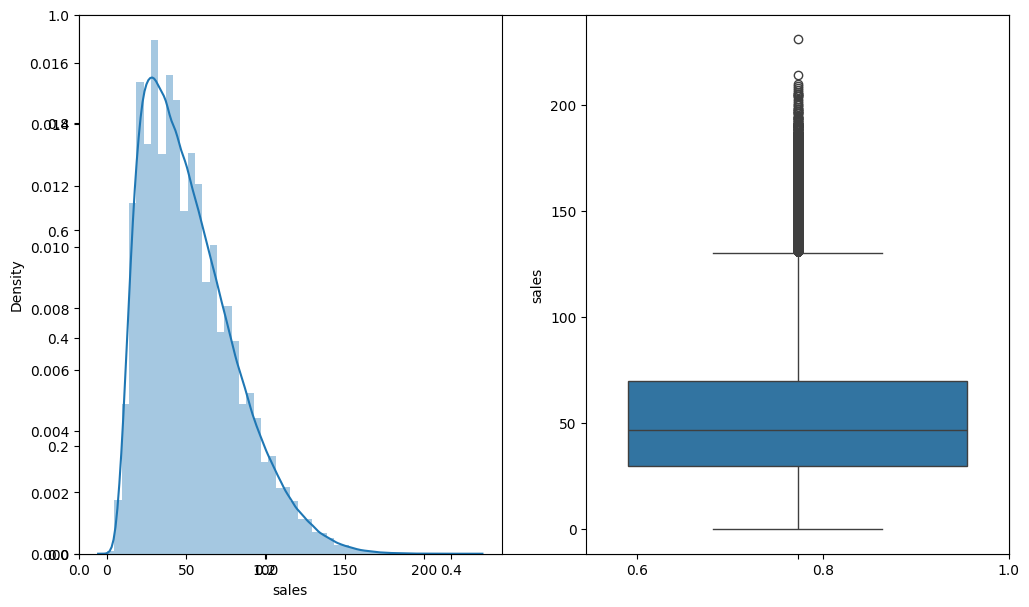

In [ ]:
plt.subplots(figsize =(12,7))
plt.subplot(1,2,1)
sns.distplot(df['sales'])

plt.subplot(1,2,2)
sns.boxplot(df['sales'])
plt.show()

<Axes: >

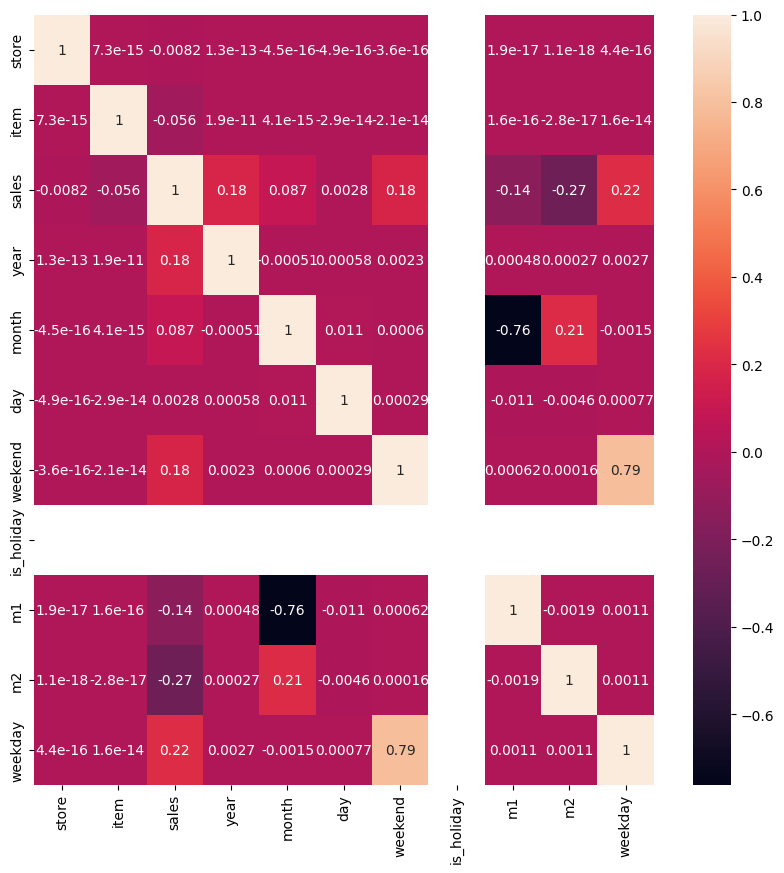

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot = True)

In [ ]:
df = df[df['sales']<140]

 # Model Training

In [ ]:
features = df.drop(['sales','year'],axis =1)
target = df['sales']
X_train, X_test ,y_train,y_test = train_test_split(features,target,test_size = 0.2, random_state = 42)

In [ ]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [ ]:
model = RandomForestRegressor(n_estimators= 200, min_samples_split=3)
model.fit(X_train,y_train)


RandomForestRegressor(min_samples_split=3, n_estimators=200)

In [ ]:
model.score(X_test,y_test)

0.8739564994487602

In [ ]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test,y_pred)
rmse

9.797867602793403

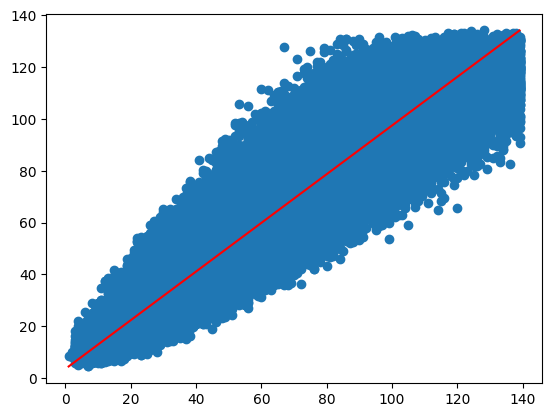

In [ ]:
plt.scatter(y_test,y_pred)
plt.plot(np.linspace(y_test.min(),y_test.max()),np.linspace(y_pred.min(),y_pred.max()),color ='red')